# A Hybrid Model for Opinion Formation


This notebook presents a multi-layered simulation of opinion dynamics using two complementary approaches:

1. **Expected Utility Model**: This model is based on game heory where actors with a position, salience and capability influence others.
2. **Opinion Dynamics**: This model is based on statistical mechanics where the players' opinions evolve via local majority influence.
3. **Hybrid Model**: Combines both paradigms with strong influencers and a social network structure.

We consider a toy example of vaccine mandates in some hypothetical country. As expected, people can be pro-vaccination or anti-vaccination or just undecided. We'll explore how opinions form, shift, and stabilize in different conditions for this example.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
from ipywidgets import interact, IntSlider, FloatSlider

## Opinion Formation

### Expected Utility Model


In this model, each actor is characterized by:

- \$ p_i \$ : position on the issue
- \$ s_i \$: salience (importance of the issue to the actor)
- \$ c_i \$: capability (power to influence others)

Actors interact by applying **pressure** to move others closer to their position.

We define an influence score:
\$
M_i = s_i \cdot c_i
\$

This makes sense since you could have a lot of influence but if you do not care about the issue, effectively your influence is zero.


In [2]:
'''
Defining the agents and the mechanism by which they interact, based on the PG model.
'''

import numpy as np

class StrategicAgent:
    def __init__(self, id, position, salience, capability):
        self.id = id
        self.position = position
        self.salience = salience
        self.capability = capability

    def influence_score(self):
        return self.salience * self.capability

    def shift_position(self, others):

        convergence_paramter = 0.2 # A parameter describing how strongly someone shifts their position
        
        # Average position of others weighted by influence
        total_weight = sum(o.influence_score() for o in others)
        if total_weight == 0:
            return
        new_position = sum(o.position * o.influence_score() for o in others) / total_weight
        self.position += convergence_paramter * (new_position - self.position) 


#### Simulating Strategic Convergence

Here we consider a simulation of 20 agents and notice that after around 20 time steps, they reach a common conclusion. This simulation 20 identical agents and thus, it is not surprising that the equilibrium posotion is near zero.

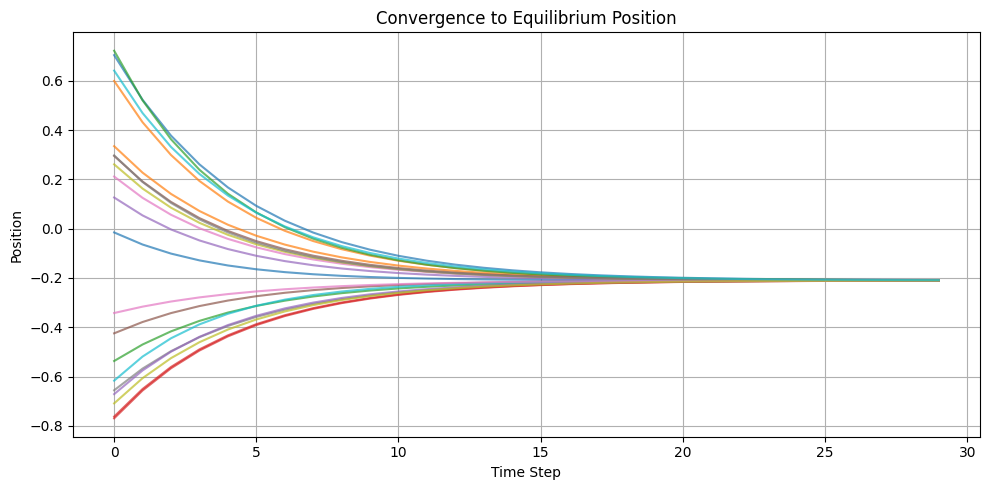

In [3]:
# Creating agents

agents = [StrategicAgent(i, np.random.uniform(-1, 1), np.random.rand(), np.random.rand()) for i in range(20)]

# Simulate position updates

history = []
for t in range(30):
    for agent in agents:
        others = [a for a in agents if a.id != agent.id]
        agent.shift_position(others)
    history.append([a.position for a in agents])

# Ploting the behaviour

plt.figure(figsize=(10, 5))
for i in range(len(agents)):
    plt.plot([h[i] for h in history], label=f"Agent {i}", alpha=0.7)
plt.title("Convergence to Equilibrium Position")
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.grid(True)
plt.tight_layout()
plt.show()


### Opinion Dynamics

This model is conceptually simpler and is based on simple statistical rules. Each agent holds one of three opinions:
- \$ o_i \in \{-1, 0, +1\} \$ : Anti, Undecided, or Pro

They adopt the majority view of their local neighborhood.


In [14]:
'''
Defining the agents based on the Galam model.
'''

class GalamAgent:
    def __init__(self, id, opinion):
        self.id = id
        self.opinion = opinion

    # This implements the local majority rule
    def decide(self, neighbors):
        total_sum = sum(n.opinion for n in neighbors if n.opinion != 0)
        if self.opinion == 0:
            if total_sum > 0:
                self.opinion = 1
            elif total_sum < 0:
                self.opinion = -1
        else:
            opposing = -self.opinion
            
            pressure = sum(n.opinion for n in neighbors if n.opinion == opposing)
            support = sum(n.opinion for n in neighbors if n.opinion == self.opinion)
            if pressure > support:
                self.opinion = opposing


#### Simulating Opinion Formation

Here we consider a simulation of 100 agents who all start with some random choice of opinions. Here, we simply shuffle these people in some groups and apply the majority update. This is obviously not so realstic and we will amend that in the next section. Regardless, we can see that immediately after a few cycles, the undecided faction disappears and a coalition for each opinion forms. 

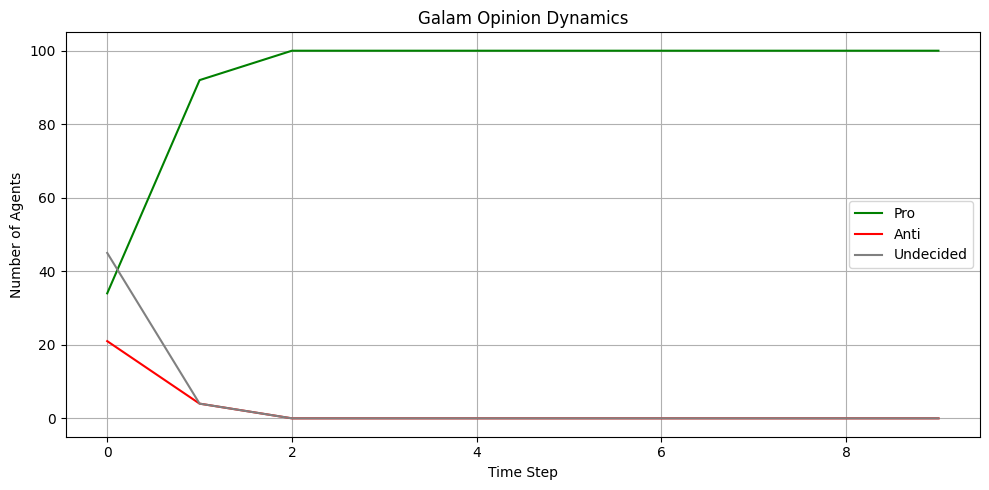

In [15]:
# Create agents
agents = [GalamAgent(i, np.random.choice([-1, 0, 1])) for i in range(100)]

# Simulate
history = []
for t in range(10):
    history.append([a.opinion for a in agents])
    np.random.shuffle(agents)
    for agent in agents:
        neighbors = np.random.choice(agents, size=5, replace=False)
        agent.decide(neighbors)

# Plot opinion counts over time
history = np.array(history)
plt.figure(figsize=(10, 5))
plt.plot(np.sum(history == 1, axis=1), label="Pro", color="green")
plt.plot(np.sum(history == -1, axis=1), label="Anti", color="red")
plt.plot(np.sum(history == 0, axis=1), label="Undecided", color="gray")
plt.title("Galam Opinion Dynamics")
plt.xlabel("Time Step")
plt.ylabel("Number of Agents")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Hybrid Model


In this model, we combine the previous approaches and do a much more realistic simulation. As before, we have a collection of agents but this time, they are related bya network structure. We assume a **Watts–Strogatz** graph which is a commonly studied model of social networks. 

We also introduce influencers, which are simply people who can influence a large group of people. This can be thought of as proxies for goverment officials or some social media channels or even celebrities.

In [35]:
'''
Defining the agents based on the hybrid model.
'''

class HybridAgent:
    def __init__(self, id, opinion, salience, capability):
        self.id = id
        self.opinion = opinion
        self.salience = salience
        self.capability = capability

    def influence_score(self):
        return self.salience * self.capability

    # This implements the local majority rule
    def decide(self, neighbors):
        weighted_sum = sum(n.opinion * n.influence_score() for n in neighbors if n.opinion != 0)
        if self.opinion == 0:
            if weighted_sum > 0:
                self.opinion = 1
            elif weighted_sum < 0:
                self.opinion = -1
        else:
            opposing = -self.opinion
            
            pressure = sum(n.influence_score() for n in neighbors if n.opinion == opposing)
            support = sum(n.influence_score() for n in neighbors if n.opinion == self.opinion)
            if pressure > support:# and np.random.rand() < 0.1:
                self.opinion = opposing


class Influencer(HybridAgent):
    def broadcast(self, agents, strength=0.5):
        for agent in agents:
            if self.opinion != agent.opinion and self.influence_score() > agent.influence_score():
                if np.random.rand() < strength:
                    agent.opinion = self.opinion

In [119]:
def build_network(n=100, k=6, p=0.2):
    return nx.watts_strogatz_graph(n, k, p)

def hybrid_simulation(n_agents=100, influencer_strength=0.5):
    G = build_network(n_agents, k=6, p=0.1)
    agents = [HybridAgent(i, np.random.choice([-1, 0, 1]), np.random.rand(), np.random.rand()) for i in range(n_agents)]

    influencers = [
        Influencer("Pro", 1, 1.0, 1.0),
        Influencer("Anti", -1, 1.0, 1)
    ]
    
    history = []
    
    for t in range(50):
        history.append([a.opinion for a in agents])
        for i, agent in enumerate(agents):
            neighbors = [agents[j] for j in G.neighbors(i)]
            agent.decide(neighbors)

        np.random.shuffle(influencers)
        for influencer in influencers:
            influencer.broadcast(agents, strength=influencer_strength)

    # Create a figure and a set of subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    # Plot network on the first subplot (ax1)
    colors = {1: 'green', -1: 'red', 0: 'gray'}
    node_colors = [colors[a.opinion] for a in agents]
    #pos = nx.spring_layout(G, seed=42)
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=100, ax=ax1)
    ax1.set_title("Final Opinions on Network")

    # Plot followers over time on the second subplot (ax2)
    history = np.array(history)
    ax2.plot(np.sum(history == 1, axis=1), label="Pro", color="green")
    ax2.plot(np.sum(history == -1, axis=1), label="Anti", color="red")
    ax2.plot(np.sum(history == 0, axis=1), label="Undecided", color="gray")
    ax2.set_xlabel("Time Step")
    ax2.set_ylabel("Number of Agents")
    ax2.set_title("Public Opinion Over Time")
    ax2.legend()
    ax2.grid(True)

    plt.show()

Here we again consider 100 agents and two influencers which are pro- and anti- respectively.

Here, I have added sliders which can change several global parameters like the number of agents or the strength of influencers etc.


In [121]:
interact(
    hybrid_simulation,
    n_agents=IntSlider(100, min=20, max=200, step=10, description="Agents"),
    influencer_strength=FloatSlider(0.5, min=0.0, max=1.0, step=0.1, description="Influencer Strength"),
)

interactive(children=(IntSlider(value=100, description='Agents', max=200, min=20, step=10), FloatSlider(value=…

<function __main__.hybrid_simulation(n_agents=100, influencer_strength=0.5)>

We notice here that the opinion shifts over time and does not really settle to a fixed stance. Unlike the previous case where one opinion completely died out, here both factions are clearly strong and survive indefinitely. This is a much more realisic scenario and reflects how real world opinions form and evolve over time. 

## Insurance Risk Simulation

### Model: Assumptions

Here we define the main simulation loop. The following assumptions are made:
 - The probability $p$ that there is a claim is 0.02.
 - The claims are modeled after an exponential distribution with mean $\mu=2000$.
 - A premium is collected monthly and its price is based on the standard deviation principle.
 - We assume expenses are 20% of the total collected premiums.

**Setup:** $N$ insured parties, claim probability $p$, claim size: $X \sim \text{Exponential}(\mu)$

**Parameters:** $E[X] = \mu$, $\text{Var}(X) = \mu^2$

**Expected Total Claims:** $C = NpE[X]$

We calculate the premium using the standard deviation principle
$$P = E[X] + \theta \sqrt{Var(X)}=p\mu(1 + \theta),$$
where $\theta$ is the risk loading parameter.Thus, the total revenue is 
$$R =Np\mu(1 + \theta)$$



In [53]:
def calculate_premium(mu, theta, p):
    return  p * mu * (1 + theta)


We now finally study, given the choice to buy an insurance policy, how such a population would behave with time. We modify the agent's behaviour and include the ability to buy and potentially renew insurance policies.

In [133]:
threshold_price= 150
prob_below_threshold_pro = 0.5
prob_above_threshold_pro = 0.1

prob_below_threshold_undecided = 0.2
prob_above_threshold_undecided = 0.05

buy_prob_anti = 0

buy_prob_neighbor_multiplier = 0.02

prob_renewal_pro = 0.95
prob_renewal_undecided = 0
prob_renewal_anti = 0.01

renewal_prob_claim_multiplier = 0.1
renewal_prob_neighbor_multiplier = 0.02


class ModifiedGalamAgent:
    """We modify the class from the previous section to introduce two new behaviours related to buying and renewing insurance policies"""
    def __init__(self, id, opinion, salience, capability):
        self.id = id
        self.opinion = opinion
        self.salience = salience
        self.capability = capability
        self.has_policy = False
        self.policy_start = None
        self.policy_end = None
        self.claims_count = 0
        
    def influence_score(self):
        return self.salience * self.capability

    # This implements the local majority rule
    def decide(self, neighbors):
        weighted_sum = sum(n.opinion * n.influence_score() for n in neighbors if n.opinion != 0)
        if self.opinion == 0:
            if weighted_sum > 0:
                self.opinion = 1
            elif weighted_sum < 0:
                self.opinion = -1
        else:
            opposing = -self.opinion
            pressure = sum(n.influence_score() for n in neighbors if n.opinion == opposing)
            support = sum(n.influence_score() for n in neighbors if n.opinion == self.opinion)
            if pressure > support: # and np.random.rand() < 0.1:
                self.opinion = opposing

    # here we add the new behaviour for buying and renewing policies
    
    def purchase_decision(self, premium, neighbors, current_time, term_length=12):
        """ The purchase decision is based on the opinion and the premuim price and the decision of both the agent and its neighbors """
        if self.has_policy:
            return False
            
        if self.opinion == 1: # Pro
            buy_prob = prob_below_threshold_pro if premium < threshold_price else prob_below_threshold_pro
        elif self.opinion == 0: # Undecided
            buy_prob = prob_below_threshold_undecided if premium < threshold_price else prob_above_threshold_undecided
        else: # Anti
            buy_prob = buy_prob_anti

        # if the agent's neighbors have insurance and claims before, the overall probability gets boosted
        buy_prob += buy_prob_neighbor_multiplier * sum(n.claims_count for n in neighbors if n.has_policy)

        if np.random.rand() < buy_prob:
            self.has_policy = True
            self.policy_start = current_time
            self.policy_end = current_time + term_length
            return True
        return False
    
    def renewal_decision(self, premium, current_time, neighbors):
        """ The renewal decision is based on the opinion of the agent and the claim history of both the agent and its neighbors """
        if not self.has_policy or current_time < self.policy_end:
            return False
            
        if self.opinion == 1:      # Pro
            renewal_prob = prob_renewal_pro
        elif self.opinion == 0:    # Undecided
            renewal_prob = prob_renewal_undecided
        else:                      # Anti
            renewal_prob = prob_renewal_anti

        # if the agent and its neighbors had claims before, the overall probability gets boosted
        renewal_prob += renewal_prob_claim_multiplier * self.claims_count + renewal_prob_neighbor_multiplier * sum(n.claims_count for n in neighbors)
        
        if np.random.rand() < renewal_prob:
            self.policy_start = current_time
            self.policy_end = current_time + 12
            return True
        else:
            self.has_policy = False
            return False


class ModifiedInfluencer(ModifiedGalamAgent):
    def broadcast(self, agents, strength=0.5):
        for agent in agents:
            if self.opinion != agent.opinion and self.influence_score() > agent.influence_score():
                if np.random.rand() < strength:
                    agent.opinion = self.opinion

def build_network(n=100, k=6, p=0.1):
    return nx.watts_strogatz_graph(n, k, p)

### Main Loop
Here we define the main loop for the simulation, we will track the following metrics:

- Opinion distribution
- Monthy Collected Premiums
- New Sales
- Renewals
- Lapses
- Claims
- Expenses
- Profit

In [124]:
def run_simulation(n_agents=100, n_periods=120, k=6, p=0.1, avg_claim_size=2000, theta=0.05, claim_probability=0.02,  expense_ratio=0.20):

    premium_monthly = calculate_premium(avg_claim_size, theta, claim_probability)
    G = build_network(n_agents, k=6, p=0.1)
    modified_agents = [ModifiedGalamAgent(i, np.random.choice([-1, 0, 1]), np.random.rand(), np.random.rand()) for i in range(n_agents)]

    influencers = [
        ModifiedInfluencer("Influencer Pro", 1, 1.0, 1.0),
        ModifiedInfluencer("Influencer Anti", -1, 1.0, 1.0)
    ]
    
    metrics = {
        'active_policies': [], 
        'new_sales': [], 
        'renewals': [], 
        'lapses': [],
        'premiums': [], 
        'claims': [], 
        'expenses': [], 
        'profit': [],
        'opinion_distribution': []
    }

    '''
    Run the simulation loop, first we update the opinions, then we do the accounting of policies, collected premiums etc.
    '''

    for t in range(n_periods):

        # this part is exactly the same as the previous section
        
        for i, agent in enumerate(modified_agents):
            neighbors = [modified_agents[j] for j in G.neighbors(i)]
            agent.decide(neighbors)

        np.random.shuffle(influencers)
        for influencer in influencers:
            influencer.broadcast(modified_agents, strength=0.2)

        # here we count the relevant statistics
        
        new_sales, renewals, lapses = 0, 0, 0
        for agent in modified_agents:
            neighbors = [modified_agents[j] for j in G.neighbors(agent.id)]
            if agent.has_policy and t >= agent.policy_end:
                if agent.renewal_decision(premium_monthly * 12, t, neighbors):
                    renewals += 1
                else:
                    lapses += 1
            else:
                if agent.purchase_decision(premium_monthly * 12, neighbors, t):
                    new_sales += 1

        active = sum(1 for a in modified_agents if a.has_policy and t >= a.policy_start and t < a.policy_end)
        premium_collected = active * premium_monthly
        expenses = premium_collected * expense_ratio
        
        claims_total = 0
        for agent in modified_agents:
            if agent.has_policy and t >= agent.policy_start and t < agent.policy_end:
                if np.random.rand() < claim_probability:
                    claims_total += np.random.exponential(scale=avg_claim_size)   # here we model the claim distribution
                    agent.claims_count += 1
        
        profit = premium_collected - claims_total - expenses

        opinions = [a.opinion for a in modified_agents]
        opinion_dist = [opinions.count(-1), opinions.count(0), opinions.count(1)]
        
        metrics['active_policies'].append(active)
        metrics['new_sales'].append(new_sales)
        metrics['renewals'].append(renewals)
        metrics['lapses'].append(lapses)
        metrics['premiums'].append(premium_collected)
        metrics['claims'].append(claims_total)
        metrics['expenses'].append(expenses)
        metrics['profit'].append(profit)
        metrics['opinion_distribution'].append(opinion_dist)

    return modified_agents, G, metrics

### Visualisation Code

We define some visualisations of the tracked data over the period.


In [72]:
def visualize_network(G, agents):
    """Draw the final state of the network."""
        # Plot network
    colors = {1: '#2ecc71', -1: '#e74c3c', 0: 'gray'}
    node_colors = [colors[a.opinion] for a in agents]
    
    #pos = nx.spring_layout(G, seed=42)
    pos = nx.kamada_kawai_layout(G)

    '''
    ax = axes[i]
    
    # Draw edges first with lighter color
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.1, width=0.3, edge_color='#bdc3c7')
    
    # Draw all nodes with their opinion colors
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=60, ax=ax, alpha=0.9,
                          edgecolors='white', linewidths=0.5)
    
    # Highlight insured nodes with a ring
    insured_nodes = [j for j in G.nodes() if insured[j]]
    nx.draw_networkx_nodes(G, pos, nodelist=insured_nodes, node_color='none', 
                               node_size=90, ax=ax, alpha=1.0, 
                               edgecolors='#3498db', linewidths=2.0)
    '''
    
    plt.figure(figsize=(6,6))
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=100,alpha=0.8)

    
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Anti', markerfacecolor='#e74c3c', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Undecided', markerfacecolor='#95a5a6', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Pro', markerfacecolor='#2ecc71', markersize=10)
    ]
    plt.legend(handles=legend_elements, title='Agent Opinion')
    plt.title('Final Network State')
    plt.show()        

def create_visualizations(metrics, n_periods, premium, claim_prob, claim_size):
    """Create clear visualizations of the simulation results."""
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: Combined Active Policies and Market Sentiment
    ax1 = axes[0]
    color1 = 'steelblue'
    ax1.set_title('Active Policies & Market Sentiment')
    ax1.set_xlabel('Time Period')
    ax1.set_ylabel('Number of Policies', color=color1)
    ax1.plot(metrics['active_policies'], linewidth=2, color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3)
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Number of Agents', color='darkgray')
    opinion_array = np.array(metrics['opinion_distribution'])
    ax2.plot(opinion_array[:, 0], label='Anti', color='red', alpha=0.5)
    ax2.plot(opinion_array[:, 1], label='Undecided', color='gray', alpha=0.7)
    ax2.plot(opinion_array[:, 2], label='Pro', color='green', alpha=0.7)
    ax2.tick_params(axis='y', labelcolor='darkgray')
    ax2.legend(loc='lower right')
    
    # Plot 2: Revenue vs. Costs
    ax = axes[1]
    ax.plot(metrics['premiums'], label='Premiums', color='green', linewidth=2)
    ax.plot(metrics['claims'], label='Claims', color='red', linewidth=1.5, alpha=0.5)
    ax.plot(metrics['expenses'], label='Expenses', color='orange', linewidth=2)
    ax.set_title('Revenue vs Costs')
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Amount ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Period Profit/Loss
    ax = axes[2]
    profit_color = ['green' if p > 0 else 'red' for p in metrics['profit']]
    ax.bar(range(len(metrics['profit'])), metrics['profit'], color=profit_color, alpha=0.6)
    ax.axhline(0, color='black', linestyle='-', linewidth=1)
    ax.set_title('Period Profit/Loss')
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Profit ($)')
    ax.grid(True, alpha=0.3)

    plt.suptitle(f'Insurance Market Simulation (Premium=${premium}/mo, Claim Prob={claim_prob:.1%})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def print_summary(metrics, premium, claim_prob, claim_size, expense_ratio):
    """Print clear summary statistics."""
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    
    print(f" PARAMETERS:")
    print(f"  Monthly Premium: €{premium}")
    print(f"  Claim Probability: {claim_prob:.1%} per month")
    print(f"  Average Claim: €{claim_size}")
    print(f"  Expense Ratio: {expense_ratio:.0%}")
    
    print(f"\n RESULTS:")
    print(f"  Avg Active Policies: {np.mean(metrics['active_policies']):.0f}")
    
    total_profit = sum(metrics['profit'])
    print(f"  Total Profit: €{total_profit:,.0f}")
    
    if total_profit > 0:
        print(f"  Status: PROFITABLE")
    else:
        print(f"  Status: UNPROFITABLE")
    print(f"  Total Renewals: {sum(metrics['renewals'])}")
    print(f"  Total Lapses: {sum(metrics['lapses'])}")
    
    if sum(metrics['renewals']) > 0:
        retention_rate = sum(metrics['renewals']) / (sum(metrics['renewals']) + sum(metrics['lapses']))
        print(f"  Retention Rate: {retention_rate:.1%}")

### Simulating 

Here we again consider 100 agents and two influencers which are pro- and anti- respectively.

Here, I have added sliders which can change several global parameters like the number of agents or the strength of influencers etc.

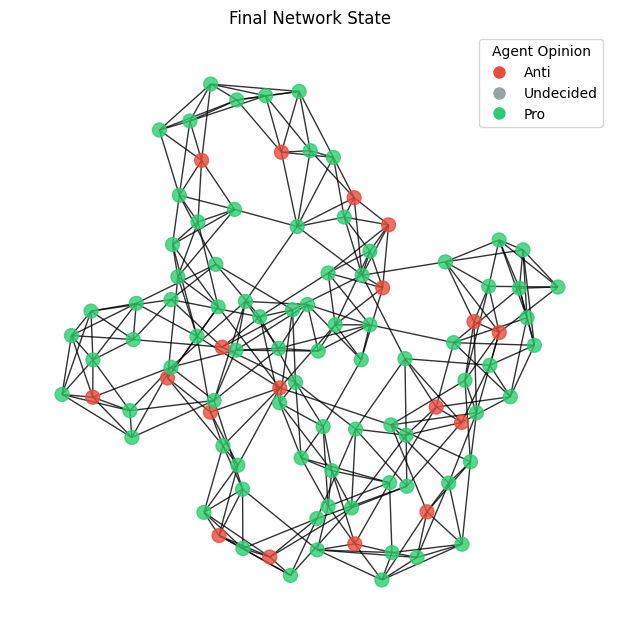

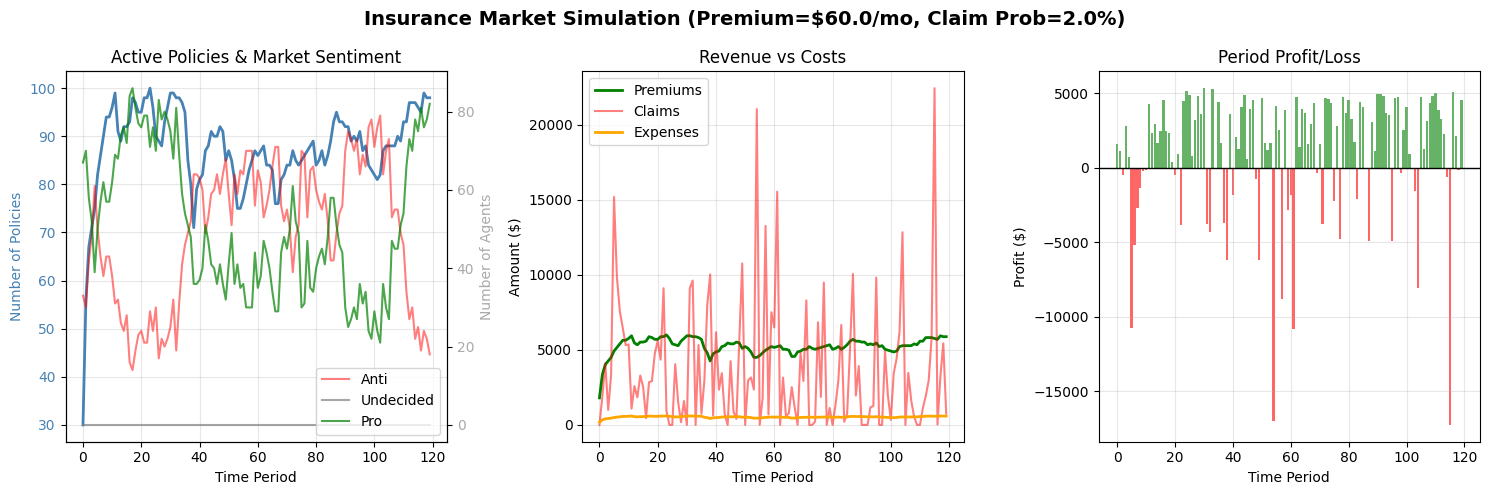


SUMMARY
 PARAMETERS:
  Monthly Premium: €60.0
  Claim Probability: 2.0% per month
  Average Claim: €2000
  Expense Ratio: 10%

 RESULTS:
  Avg Active Policies: 88
  Total Profit: €129,539
  Status: PROFITABLE
  Total Renewals: 515
  Total Lapses: 305
  Retention Rate: 62.8%


In [137]:
n_agents=100
n_periods=120
k=6
p=0.1


avg_claim_size=2000
theta=0.5
claim_probability=0.02
premium_monthly = calculate_premium(avg_claim_size, theta, claim_probability)
expense_ratio=0.1

final_agents, final_network, metrics = run_simulation(n_agents, n_periods, k, p, avg_claim_size, theta, claim_probability, expense_ratio)

visualize_network(final_network, final_agents)
create_visualizations(metrics, n_periods, premium_monthly, claim_probability, avg_claim_size)
print_summary(metrics, premium_monthly, claim_probability, avg_claim_size, expense_ratio)